### Jensen–Shannon Divergence

Given two discrete probability distributions \(P = (p_i)_i\) and \(Q = (q_i)_i\) over the same support,  
their Jensen–Shannon (JS) divergence with log base \(b\) is

$$
\mathrm{JSD}_{\log b}(P\|Q)
= \tfrac{1}{2}\, D_{\mathrm{KL}}(P\|M)
+ \tfrac{1}{2}\, D_{\mathrm{KL}}(Q\|M),
\quad
\text{where } M = \tfrac{1}{2}(P+Q).
$$

---

The Kullback–Leibler divergence is

$$
D_{\mathrm{KL}}(P\|Q) = \sum_i p_i \log_b \frac{p_i}{q_i},
\quad
\text{with } \log_b x = \frac{\ln x}{\ln b}.
$$

- If \(b = e\), units are *nats*.  
- If \(b = 2\), units are *bits*.  

---

For tensor-shaped discrete distributions (e.g., \(p_{i,j,k}\)), the same definition applies with a sum over all indices in the support:

$$
D_{\mathrm{KL}}(P\|Q) =
\sum_{i,j,k,\dots} p_{i,j,k,\dots}\,
\log_b \frac{p_{i,j,k,\dots}}{q_{i,j,k,\dots}},
$$

and the Jensen–Shannon divergence is

$$
\mathrm{JSD}(P\|Q)
= \tfrac{1}{2}\, D_{\mathrm{KL}}(P\|M)
+ \tfrac{1}{2}\, D_{\mathrm{KL}}(Q\|M).
$$


In [1]:
# If JAX isn't available in your Colab runtime, uncomment the next line:
# !pip -q install --upgrade "jax[cpu]"

import jax.numpy as jnp

def logb(x, base):
    """Logarithm with arbitrary base (base='e' for natural log, 2 for bits, 10 for decibels)."""
    if base == 'e':
        return jnp.log(x)
    elif base == 2:
        return jnp.log(x) / jnp.log(jnp.array(2.0, x.dtype))
    elif base == 10:
        return jnp.log(x) / jnp.log(jnp.array(10.0, x.dtype))
    else:
        base = jnp.array(base, x.dtype)
        return jnp.log(x) / jnp.log(base)

def normalize_to_prob(x, epsilon=1e-12, flatten=True):
    """
    Turn a nonnegative tensor into a probability distribution.
    If flatten=True, the whole tensor is treated as one distribution over all entries.
    """
    x = x.astype(jnp.float32)
    if flatten:
        x = jnp.ravel(x)
    # Make strictly positive (avoids log(0) later)
    x = x + epsilon
    s = x.sum()
    return x / s

def js_divergence_verbose(P_raw, Q_raw, base=2, epsilon=1e-12, flatten=True, name=""):
    """
    Compute JS divergence with very verbose prints showing each inner step.
    JS(P||Q) = 0.5 * KL(P||M) + 0.5 * KL(Q||M),  where M=(P+Q)/2
    """
    print("\n" + "="*80)
    title = f"[{name}] " if name else ""
    print(f"{title}Jensen–Shannon Divergence (base={base})")
    print("-"*80)

    # 1) Show raw inputs
    print("Raw P:", P_raw)
    print("Raw Q:", Q_raw)

    # 2) Normalize both into valid probability distributions
    P = normalize_to_prob(P_raw, epsilon=epsilon, flatten=flatten)
    Q = normalize_to_prob(Q_raw, epsilon=epsilon, flatten=flatten)

    print("\nStep 1 — Normalize to probabilities")
    print("P (normalized):", P)
    print("Q (normalized):", Q)
    print("sum(P) =", P.sum(), "  sum(Q) =", Q.sum())

    # 3) Mixture distribution
    M = 0.5 * (P + Q)
    print("\nStep 2 — Mixture distribution")
    print("M = 0.5 * (P + Q):", M)
    print("sum(M) =", M.sum())

    # 4) Elementwise KL terms
    # KL(P||M) = sum_i P_i * log_b(P_i/M_i)
    # KL(Q||M) = sum_i Q_i * log_b(Q_i/M_i)
    print("\nStep 3 — Elementwise KL components")
    log_PM = logb(P, base) - logb(M, base)  # log_b(P/M)
    log_QM = logb(Q, base) - logb(M, base)  # log_b(Q/M)

    term_P = P * log_PM
    term_Q = Q * log_QM

    print("log_b(P/M):", log_PM)
    print("log_b(Q/M):", log_QM)
    print("P * log_b(P/M):", term_P)
    print("Q * log_b(Q/M):", term_Q)

    kl_PM = term_P.sum()
    kl_QM = term_Q.sum()
    print("\nStep 4 — Sum of KL parts")
    print("KL(P || M) =", kl_PM)
    print("KL(Q || M) =", kl_QM)

    # 5) JS divergence
    jsd = 0.5 * (kl_PM + kl_QM)
    print("\nStep 5 — JS divergence")
    print("JS(P || Q) = 0.5 * (KL(P||M) + KL(Q||M)) =", jsd)
    print("="*80)
    return jsd

def make_pair(shape):
    """
    Deterministic example pair (P_raw, Q_raw) for any shape:
    P_raw increases 1..N, Q_raw decreases N..1 (both > 0).
    """
    N = int(jnp.prod(jnp.array(shape)))
    P_raw = jnp.arange(1, N+1, dtype=jnp.float32).reshape(shape)
    Q_raw = jnp.arange(N, 0, -1, dtype=jnp.float32).reshape(shape)
    return P_raw, Q_raw





# ---------- DEMOS ----------
# We treat the whole tensor as ONE distribution (flatten=True),
# so probability mass is spread over all entries of the tensor.

# 1) 1-D array (length 6 for visibility)

In [2]:
P1, Q1 = make_pair((6,))
js_divergence_verbose(P1, Q1, base=2, name="1D array len=6")


[1D array len=6] Jensen–Shannon Divergence (base=2)
--------------------------------------------------------------------------------
Raw P: [1. 2. 3. 4. 5. 6.]
Raw Q: [6. 5. 4. 3. 2. 1.]

Step 1 — Normalize to probabilities
P (normalized): [0.04761905 0.0952381  0.14285715 0.1904762  0.23809524 0.2857143 ]
Q (normalized): [0.2857143  0.23809524 0.1904762  0.14285715 0.0952381  0.04761905]
sum(P) = 1.0   sum(Q) = 1.0

Step 2 — Mixture distribution
M = 0.5 * (P + Q): [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
sum(M) = 1.0

Step 3 — Elementwise KL components
log_b(P/M): [-1.8073547  -0.8073547  -0.22239232  0.19264531  0.5145731   0.7776078 ]
log_b(Q/M): [ 0.7776078   0.5145731   0.19264531 -0.22239232 -0.8073547  -1.8073547 ]
P * log_b(P/M): [-0.08606451 -0.07689092 -0.03177033  0.03669434  0.12251741  0.22217366]
Q * log_b(Q/M): [ 0.22217366  0.12251741  0.03669434 -0.03177033 -0.07689092 -0.08606451]

Step 4 — Sum of KL parts
KL(P || M) = 0.18665965
KL(Q || M)

Array(0.18665966, dtype=float32)

# 2) 2x2 matrix

In [3]:
P2, Q2 = make_pair((2, 2))
js_divergence_verbose(P2, Q2, base=2, name="2x2 matrix")


[2x2 matrix] Jensen–Shannon Divergence (base=2)
--------------------------------------------------------------------------------
Raw P: [[1. 2.]
 [3. 4.]]
Raw Q: [[4. 3.]
 [2. 1.]]

Step 1 — Normalize to probabilities
P (normalized): [0.1 0.2 0.3 0.4]
Q (normalized): [0.4 0.3 0.2 0.1]
sum(P) = 1.0   sum(Q) = 1.0

Step 2 — Mixture distribution
M = 0.5 * (P + Q): [0.25 0.25 0.25 0.25]
sum(M) = 1.0

Step 3 — Elementwise KL components
log_b(P/M): [-1.321928   -0.32192802  0.26303434  0.678072  ]
log_b(Q/M): [ 0.678072    0.26303434 -0.32192802 -1.321928  ]
P * log_b(P/M): [-0.1321928  -0.06438561  0.07891031  0.2712288 ]
Q * log_b(Q/M): [ 0.2712288   0.07891031 -0.06438561 -0.1321928 ]

Step 4 — Sum of KL parts
KL(P || M) = 0.15356068
KL(Q || M) = 0.15356068

Step 5 — JS divergence
JS(P || Q) = 0.5 * (KL(P||M) + KL(Q||M)) = 0.15356068


Array(0.15356068, dtype=float32)

# 3) 3x3 matrix

In [4]:
P3, Q3 = make_pair((3, 3))
js_divergence_verbose(P3, Q3, base=2, name="3x3 matrix")


[3x3 matrix] Jensen–Shannon Divergence (base=2)
--------------------------------------------------------------------------------
Raw P: [[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
Raw Q: [[9. 8. 7.]
 [6. 5. 4.]
 [3. 2. 1.]]

Step 1 — Normalize to probabilities
P (normalized): [0.02222222 0.04444445 0.06666667 0.08888889 0.11111111 0.13333334
 0.15555556 0.17777778 0.2       ]
Q (normalized): [0.2        0.17777778 0.15555556 0.13333334 0.11111111 0.08888889
 0.06666667 0.04444445 0.02222222]
sum(P) = 1.0   sum(Q) = 1.0

Step 2 — Mixture distribution
M = 0.5 * (P + Q): [0.11111111 0.11111111 0.11111112 0.11111112 0.11111111 0.11111112
 0.11111112 0.11111111 0.11111111]
sum(M) = 1.0

Step 3 — Elementwise KL components
log_b(P/M): [-2.3219283  -1.3219283  -0.73696566 -0.32192826  0.          0.26303434
  0.4854269   0.678072    0.84799695]
log_b(Q/M): [ 0.84799695  0.678072    0.4854269   0.26303434  0.         -0.32192826
 -0.73696566 -1.3219283  -2.3219283 ]
P * log_b(P/M): [-0.05159841 -0.05

Array(0.21262997, dtype=float32)

# 4) 5x5 matrix

In [5]:
P5, Q5 = make_pair((5, 5))
js_divergence_verbose(P5, Q5, base=2, name="5x5 matrix")


[5x5 matrix] Jensen–Shannon Divergence (base=2)
--------------------------------------------------------------------------------
Raw P: [[ 1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10.]
 [11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20.]
 [21. 22. 23. 24. 25.]]
Raw Q: [[25. 24. 23. 22. 21.]
 [20. 19. 18. 17. 16.]
 [15. 14. 13. 12. 11.]
 [10.  9.  8.  7.  6.]
 [ 5.  4.  3.  2.  1.]]

Step 1 — Normalize to probabilities
P (normalized): [0.00307692 0.00615385 0.00923077 0.01230769 0.01538462 0.01846154
 0.02153846 0.02461538 0.02769231 0.03076923 0.03384615 0.03692308
 0.04       0.04307692 0.04615385 0.04923077 0.05230769 0.05538461
 0.05846154 0.06153846 0.06461538 0.06769231 0.07076923 0.07384615
 0.07692308]
Q (normalized): [0.07692308 0.07384615 0.07076923 0.06769231 0.06461538 0.06153846
 0.05846154 0.05538461 0.05230769 0.04923077 0.04615385 0.04307692
 0.04       0.03692308 0.03384615 0.03076923 0.02769231 0.02461538
 0.02153846 0.01846154 0.01538462 0.01230769 0.00923077 0.00615385
 0.003

Array(0.25210792, dtype=float32)

# 5) 3x3x3 tensor

In [6]:
P333, Q333 = make_pair((3, 3, 3))
js_divergence_verbose(P333, Q333, base=2, name="3x3x3 tensor")


[3x3x3 tensor] Jensen–Shannon Divergence (base=2)
--------------------------------------------------------------------------------
Raw P: [[[ 1.  2.  3.]
  [ 4.  5.  6.]
  [ 7.  8.  9.]]

 [[10. 11. 12.]
  [13. 14. 15.]
  [16. 17. 18.]]

 [[19. 20. 21.]
  [22. 23. 24.]
  [25. 26. 27.]]]
Raw Q: [[[27. 26. 25.]
  [24. 23. 22.]
  [21. 20. 19.]]

 [[18. 17. 16.]
  [15. 14. 13.]
  [12. 11. 10.]]

 [[ 9.  8.  7.]
  [ 6.  5.  4.]
  [ 3.  2.  1.]]]

Step 1 — Normalize to probabilities
P (normalized): [0.0026455  0.00529101 0.00793651 0.01058201 0.01322751 0.01587302
 0.01851852 0.02116402 0.02380952 0.02645503 0.02910053 0.03174603
 0.03439153 0.03703704 0.03968254 0.04232804 0.04497354 0.04761905
 0.05026455 0.05291005 0.05555556 0.05820106 0.06084656 0.06349207
 0.06613757 0.06878307 0.07142857]
Q (normalized): [0.07142857 0.06878307 0.06613757 0.06349207 0.06084656 0.05820106
 0.05555556 0.05291005 0.05026455 0.04761905 0.04497354 0.04232804
 0.03968254 0.03703704 0.03439153 0.03174603 0.0

Array(0.2539453, dtype=float32)

# 6) 3x3x3x3 tensor

In [7]:
P3333, Q3333 = make_pair((3, 3, 3, 3))
js_divergence_verbose(P3333, Q3333, base=2, name="3x3x3x3 tensor")


[3x3x3x3 tensor] Jensen–Shannon Divergence (base=2)
--------------------------------------------------------------------------------
Raw P: [[[[ 1.  2.  3.]
   [ 4.  5.  6.]
   [ 7.  8.  9.]]

  [[10. 11. 12.]
   [13. 14. 15.]
   [16. 17. 18.]]

  [[19. 20. 21.]
   [22. 23. 24.]
   [25. 26. 27.]]]


 [[[28. 29. 30.]
   [31. 32. 33.]
   [34. 35. 36.]]

  [[37. 38. 39.]
   [40. 41. 42.]
   [43. 44. 45.]]

  [[46. 47. 48.]
   [49. 50. 51.]
   [52. 53. 54.]]]


 [[[55. 56. 57.]
   [58. 59. 60.]
   [61. 62. 63.]]

  [[64. 65. 66.]
   [67. 68. 69.]
   [70. 71. 72.]]

  [[73. 74. 75.]
   [76. 77. 78.]
   [79. 80. 81.]]]]
Raw Q: [[[[81. 80. 79.]
   [78. 77. 76.]
   [75. 74. 73.]]

  [[72. 71. 70.]
   [69. 68. 67.]
   [66. 65. 64.]]

  [[63. 62. 61.]
   [60. 59. 58.]
   [57. 56. 55.]]]


 [[[54. 53. 52.]
   [51. 50. 49.]
   [48. 47. 46.]]

  [[45. 44. 43.]
   [42. 41. 40.]
   [39. 38. 37.]]

  [[36. 35. 34.]
   [33. 32. 31.]
   [30. 29. 28.]]]


 [[[27. 26. 25.]
   [24. 23. 22.]
   [21. 20. 19

Array(0.27001446, dtype=float32)

# NOTE:
# - Set base='e' above if you prefer nats, or base=10 for log10 units.
# - Set flatten=False if you want to keep a particular axis as the probability axis,
#   then modify normalize_to_prob to sum along that axis instead of over all entries.

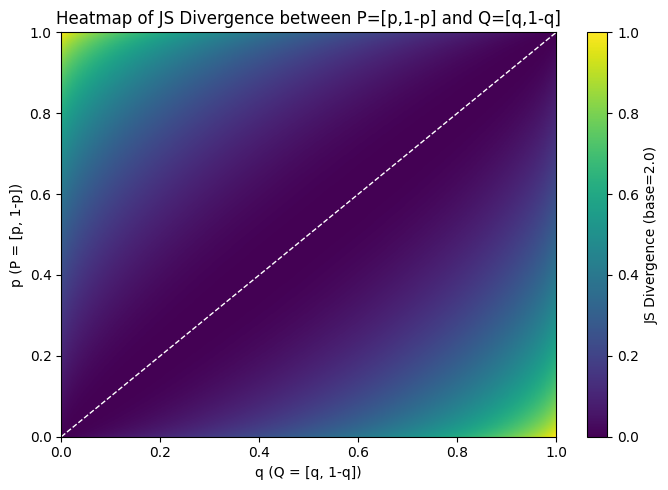

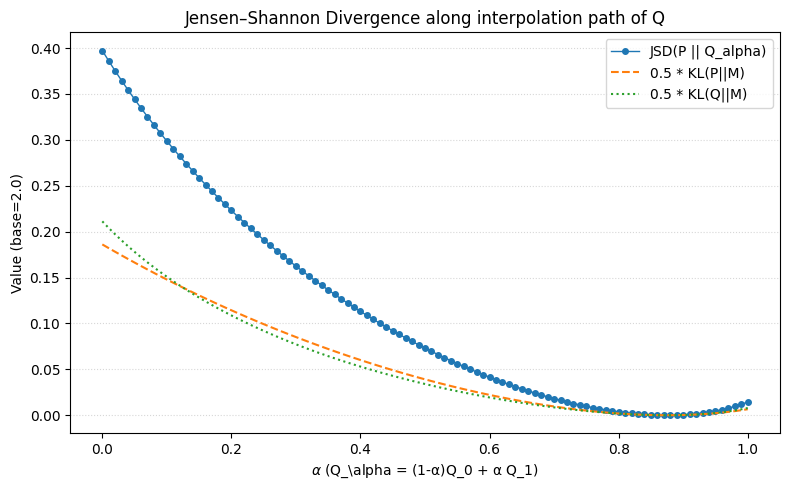

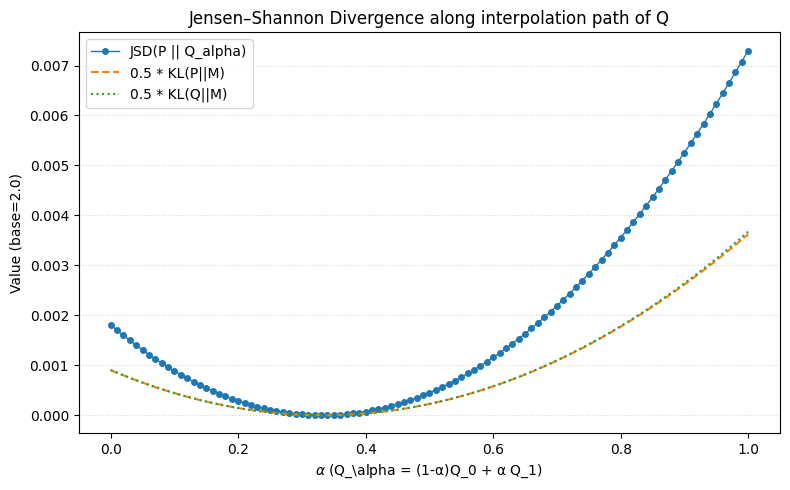

In [10]:
# JS divergence visualizations: heatmap for 2-bin distributions + interpolation plot
import numpy as np
import matplotlib.pyplot as plt

# ---------- Utilities ----------
def safe_log(x):
    """Stable log avoiding log(0)."""
    eps = 1e-15
    return np.log(np.clip(x, eps, None))

def kl_divergence(p, q, base=2.0):
    """KL(P||Q) for discrete distributions p and q (same shape)."""
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    # assume p and q sum to 1 (but small epsilon to avoid log(0))
    return np.sum(np.where(p > 0, p * (safe_log(p) - safe_log(q)), 0.0)) / np.log(base)

def js_divergence(p, q, base=2.0):
    """Jensen-Shannon divergence (base default 2 -> bits)."""
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m, base=base) + 0.5 * kl_divergence(q, m, base=base)

# ---------- 1) Heatmap for 2-bin distributions ----------
def plot_js_heatmap(resolution=201, base=2.0):
    """
    Computes JSD for P=[p,1-p], Q=[q,1-q] on a grid and plots heatmap.
    resolution: number of points per axis (odd numbers give center at 0.5)
    """
    xs = np.linspace(0.0, 1.0, resolution)
    grid = np.zeros((resolution, resolution))
    for i, p in enumerate(xs):
        P = np.array([p, 1.0 - p])
        for j, q in enumerate(xs):
            Q = np.array([q, 1.0 - q])
            grid[i, j] = js_divergence(P, Q, base=base)

    plt.figure(figsize=(7, 5))
    im = plt.imshow(grid, origin='lower', extent=[0,1,0,1], aspect='auto')
    plt.colorbar(im, label=f'JS Divergence (base={base})')
    plt.xlabel('q (Q = [q, 1-q])')
    plt.ylabel('p (P = [p, 1-p])')
    plt.title('Heatmap of JS Divergence between P=[p,1-p] and Q=[q,1-q]')
    # draw diagonal line p=q (zero divergence)
    plt.plot([0,1],[0,1], color='white', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()
    return xs, grid

# ---------- 2) Interpolation path plot ----------
def plot_js_along_path(P, Q0, Q1, steps=201, base=2.0):
    """
    Fix P; interpolate Q_alpha = (1-alpha)*Q0 + alpha*Q1 for alpha in [0,1].
    Plot JS(P||Q_alpha) vs alpha. Also plot KL parts if desired.
    P, Q0, Q1 must be same-length arrays and sum to 1 (function will normalize).
    """
    P = np.asarray(P, dtype=float)
    Q0 = np.asarray(Q0, dtype=float)
    Q1 = np.asarray(Q1, dtype=float)

    # normalize to ensure valid distributions
    def norm(v):
        v = np.asarray(v, dtype=float)
        s = v.sum()
        if s == 0:
            return np.ones_like(v) / v.size
        return v / s

    P = norm(P)
    Q0 = norm(Q0)
    Q1 = norm(Q1)

    alphas = np.linspace(0.0, 1.0, steps)
    js_vals = np.zeros_like(alphas)
    kl_p_vals = np.zeros_like(alphas)
    kl_q_vals = np.zeros_like(alphas)

    for idx, a in enumerate(alphas):
        Qa = (1 - a) * Q0 + a * Q1
        Qa = norm(Qa)
        js_vals[idx] = js_divergence(P, Qa, base=base)
        # for diagnostic: KL(P||M) and KL(Q||M)
        M = 0.5 * (P + Qa)
        kl_p_vals[idx] = kl_divergence(P, M, base=base)
        kl_q_vals[idx] = kl_divergence(Qa, M, base=base)

    plt.figure(figsize=(8, 5))
    plt.plot(alphas, js_vals, label='JSD(P || Q_alpha)', marker='o', markersize=4, linewidth=1)
    # optional: plot the two KL components (scaled by 0.5)
    plt.plot(alphas, 0.5*kl_p_vals, label='0.5 * KL(P||M)', linestyle='--')
    plt.plot(alphas, 0.5*kl_q_vals, label='0.5 * KL(Q||M)', linestyle=':')
    plt.xlabel(r'$\alpha$ (Q_\alpha = (1-α)Q_0 + α Q_1)')
    plt.ylabel(f'Value (base={base})')
    plt.title('Jensen–Shannon Divergence along interpolation path of Q')
    plt.legend()
    plt.grid(axis='y', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()
    return alphas, js_vals

# ---------- Run examples ----------
if __name__ == "__main__":
    # 1) Heatmap for 2-bin distributions
    xs, grid = plot_js_heatmap(resolution=401, base=2.0)  # higher resolution for smoothness

    # 2) Example interpolation: fix P and interpolate Q from Q0 to Q1
    # Example A: P biased, move Q from left-peaked to right-peaked
    P = np.array([0.8, 0.2])   # fixed P
    Q0 = np.array([0.1, 0.9])
    Q1 = np.array([0.9, 0.1])
    plot_js_along_path(P, Q0, Q1, steps=101, base=2.0)

    # Example B: symmetric P, small changes in Q
    P2 = np.array([0.5, 0.5])
    Q0b = np.array([0.45, 0.55])
    Q1b = np.array([0.6, 0.4])
    plot_js_along_path(P2, Q0b, Q1b, steps=101, base=2.0)
